In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

sys.path.append('../lib')
from local_paths import analysis_dir, database_dir, mplstyle_path
from summary_utils import annotate_unit_df, select_units, summarize_results_per_region
from stats_utils import get_bootstrap_spread

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
analysis_name = 'rsc_precision'
results_dir = analysis_dir + analysis_name

# analysis-specific conditions
return_thres_opts = (1/4, 1/2, 1, 2, 4, 8, 16)

# unit selection
unit_sel_path = database_dir + 'unit_sel/visually_selective.csv.gz'

# statistics
spread_type = 'boots_mad_of_median'

# Load data

In [4]:
unit_df = {'Session': [], 'Unit': []}
results = {k: [] for k in ('rsc',)}

results_dir = Path(results_dir).expanduser()
return_thres_opts = np.array(return_thres_opts)
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            assert f[f'progress_report/{analysis_name}/all_done'][()]
            dset = f[analysis_name+'/data/sample']
        except (KeyError, AssertionError):
            continue

    dset = xr.load_dataset(fp, group=analysis_name+'/data', engine='h5netcdf')
    dset = dset.reindex({'return_thres': return_thres_opts}, fill_value=np.nan)

    results['rsc'].append(dset['sample'][()])

    unit_names = dset['unit'].values.astype(str)
    unit_df['Session'].append(np.full(unit_names.size, fp.stem))
    unit_df['Unit'].append(unit_names)

print('results:')
for d in (results, unit_df):
    for k, v in d.items():
        d[k] = v = np.concatenate(v, axis=-1)
        print('', f'{k:<15s}', v.shape, v.dtype, sep='\t')
print(np.unique(unit_df['Session']).size, 'sessions')
unit_df = annotate_unit_df(pd.DataFrame(unit_df))

results:
	rsc            	(7, 64219)	float32
	Session        	(64219,)	<U10
	Unit           	(64219,)	<U4
654 sessions


# Select units

In [5]:
result_vals = results['rsc']
del results

In [6]:
unit_df, unit_sel, regions = select_units(
    unit_df,
    selection_path=unit_sel_path,
    select_valid_values=result_vals)
result_vals = result_vals[...,unit_sel]

> Selected units: n = 26127 of 64219 (40.7% of data, 96.9% of selection) based on visually_selective.csv.gz
> Selected units: n = 22183 of 26127 (84.9%) with valid values
> No rare subject to exclude
	 min norm. units per region: Region
	AIT    0.320828
	CIT    0.057851
	PIT    1.000000
	V1     0.954839
	V2     1.000000
	V4     0.308594
	Name: Norm. units, dtype: float64


In [7]:
unit_df.reset_index()[['Session','Unit']].to_csv('unit_sel/fig4a.csv.gz', index=False)

# Summarize results per region

In [8]:
summary = summarize_results_per_region(
    unit_df=unit_df,
    result_vals=result_vals[None,:,:],
    spread_type=spread_type)

In [9]:
known_regions = ('V1', 'V2', 'V4', 'PIT', 'CIT', 'AIT')
region_palette = {k: v for k, v in zip(known_regions, plt.get_cmap('inferno_r')(np.linspace(0.15, 0.8, len(known_regions))))}

center/spread estimate: boots_mad_of_median


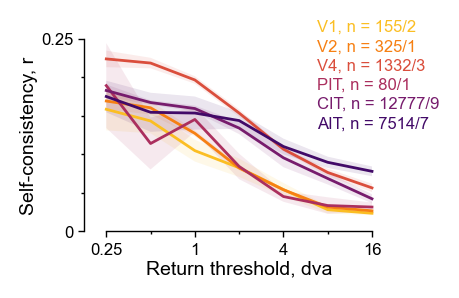

In [10]:
fig = plt.figure()
ax = plt.gca()
xs = np.log2(return_thres_opts)
icond = 0

for region in regions:
    color = region_palette[region]
    m, bs = summary['one-level_center_boots'][region]
    ax.plot(xs, m[icond], color=color)
    spread = get_bootstrap_spread(m[icond], bs[:,icond], spread_type)
    ax.fill_between(xs, *spread, ec='none', fc=color, alpha=0.1)


xtks = np.log2((1/4, 1, 4, 16))
xtkls = ('0.25', '1', '4', '16')
xbound = (xtks[0], xtks[-1])
ax.set_xlim(xbound[0]-.5, xbound[1]+.5)
ax.set_xticks(xtks, xtkls)
ax.set_xticks(xs, minor=True)
ax.spines['bottom'].set_bounds(xbound)
ax.set_xlabel('Return threshold, dva')

ybound = (0, .25)
ymtks = np.arange(*ybound, .05)
ax.set_ylim(ybound)
ax.set_yticks(ybound, list(map(str, ybound)))
ax.set_yticks(ymtks, minor=True)
ax.spines['left'].set_bounds(ybound)
ax.set_ylabel('Self-consistency, r')

h = 1.1
for region in regions:
    c = region_palette[region]
    ns = summary['two-level_nunit'][region].values()
    ns = np.array(list(ns))
    l = f'{region}, n = {ns.sum()}/{len(ns)}'
    ax.text(
        .75, h, l, ha='left', va='top',
        transform=ax.transAxes, color=c, fontsize=6)
    h -= .1

print('center/spread estimate:', spread_type)

plt.savefig('plots/fig4a.png')